In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

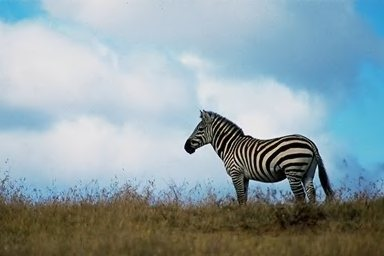

In [4]:
real_image_path = r'dataset\CASIA2\real\Au_ani_00001.jpg'
Image.open(real_image_path)

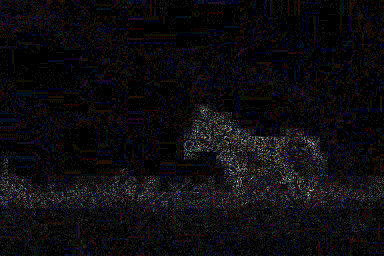

In [5]:
convert_to_ela_image(real_image_path, 90)

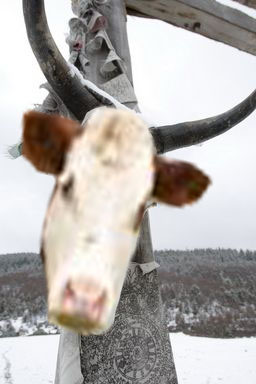

In [6]:
fake_image_path = r'dataset\CASIA2\fake\Tp_D_CRN_M_N_art00067_ani00095_11803.jpg'
Image.open(fake_image_path)

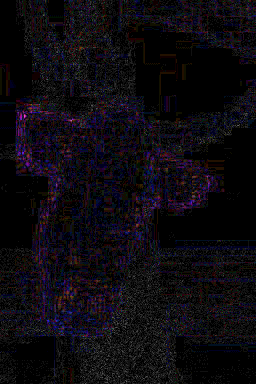

In [7]:
convert_to_ela_image(fake_image_path, 90)

In [8]:
image_size = (128, 128)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [11]:
import random
path = r'dataset\CASIA2\real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
X=X
Y=Y
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
Processing 8000 images
8435 8435


In [12]:
path = r'dataset\CASIA2\fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
11459 11459


In [13]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

9167 9167
2292 2292


In [15]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [22]:
epochs = 20
batch_size = 32

In [23]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

In [24]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [26]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/20
287/287 [==============================] - 581s 2s/step - loss: 0.3841 - accuracy: 0.7638 - val_loss: 0.3798 - val_accuracy: 0.7910
Epoch 2/20
287/287 [==============================] - 536s 2s/step - loss: 0.3504 - accuracy: 0.8004 - val_loss: 0.3197 - val_accuracy: 0.8434
Epoch 3/20
287/287 [==============================] - 485s 2s/step - loss: 0.3251 - accuracy: 0.8215 - val_loss: 0.2931 - val_accuracy: 0.8508
Epoch 4/20
287/287 [==============================] - 513s 2s/step - loss: 0.2935 - accuracy: 0.8523 - val_loss: 0.2698 - val_accuracy: 0.8599
Epoch 5/20
287/287 [==============================] - 594s 2s/step - loss: 0.2686 - accuracy: 0.8698 - val_loss: 0.2834 - val_accuracy: 0.8691
Epoch 6/20
287/287 [==============================] - 505s 2s/step - loss: 0.2512 - accuracy: 0.8757 - val_loss: 0.2386 - val_accuracy: 0.8752
Epoch 7/20
287/287 [==============================] - 492s 2s/step - loss: 0.2369 - accuracy: 0.8869 - val_loss: 0.2308 - val_accuracy: 0.8826

In [27]:
model.save('model_casia_run3.h5')

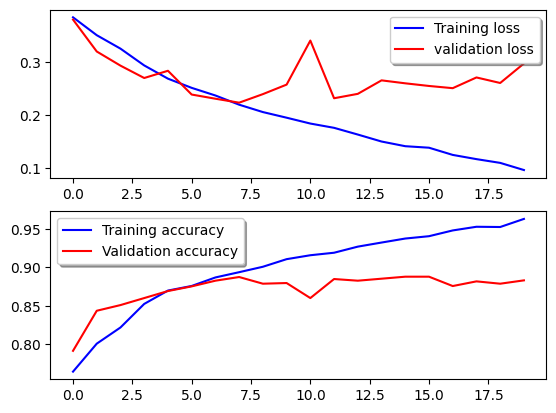

In [28]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

72/72 [==============================] - 15s 210ms/step


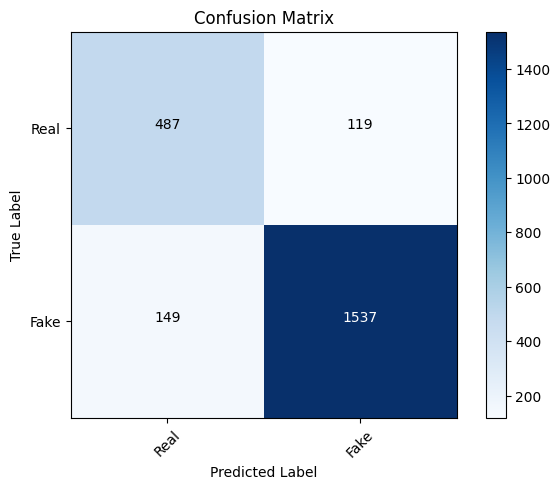

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

model = load_model('model_casia_run3.h5') 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=["Real", "Fake"])


287/287 [==============================] - 80s 276ms/step


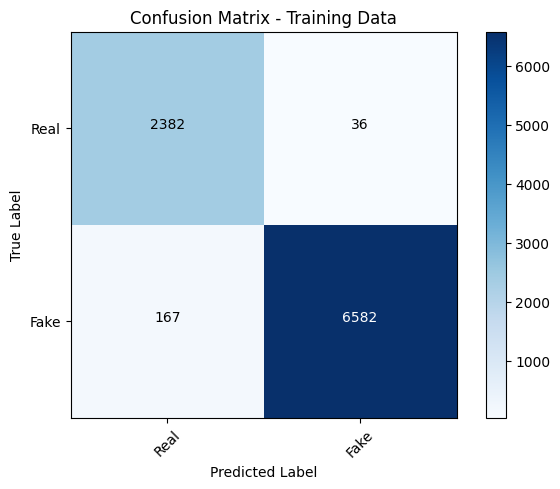

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

model = load_model('model_casia_run3.h5')

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Y_pred_train = model.predict(X_train)
Y_pred_train_classes = np.argmax(Y_pred_train, axis=1)
Y_true_train = np.argmax(Y_train, axis=1)
confusion_mtx_train = confusion_matrix(Y_true_train, Y_pred_train_classes)
plot_confusion_matrix(confusion_mtx_train, classes=["Real", "Fake"], title='Confusion Matrix - Training Data')


In [31]:
class_names = ['fake', 'real']

In [32]:
real_image_path = r'dataset\CASIA2\real\Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 289ms/step
Class: real Confidence: 100.00


In [33]:
fake_image_path = r'dataset\CASIA2\fake\Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 67ms/step
Class: fake Confidence: 98.33


In [35]:
fake_image = os.listdir(r'dataset\CASIA2\fake')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join(r'dataset\CASIA2\fake', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 33ms/step


In [37]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 3024, Correct: 2541, Acc: 84.02777777777779


In [39]:
real_image = os.listdir(r'dataset\CASIA2\real')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join(r'dataset\CASIA2\real', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 62ms/step


In [48]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 8435, Correct: 8119, Acc: 96.25370480142264
Total: 78939, Correct: 75612, Acc: 95.78535324744422


In [49]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import os

# Load the pre-trained model
model = load_model('model_casia_run1.h5')  # Load your model file

# Function to prepare the image (same preprocessing as during training)
def prepare_single_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')  # Open the image
    img = convert_to_ela_image(image_path, 90)  # Convert to ELA
    img = img.resize(target_size)  # Resize to match model input
    img = np.array(img)  # Convert image to numpy array
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to predict if the image is real or fake
def predict_image(model, image_path):
    img = prepare_single_image(image_path)
    prediction = model.predict(img)
    
    # Get the predicted class (index) and the corresponding confidence (probability)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Interpret prediction and return class and confidence
    if predicted_class == 0:
        label = "Fake"
    else:
        label = "Real"
    
    return label, confidence

# Manually provide the image path
image_path = r'C:\Users\anish\OneDrive\Desktop\MyCodes\FAKE IMAGE DETECTION SYSTEM\real_4.jpg'  

label, confidence = predict_image(model, image_path)
print(f"The image is: {label} with {confidence*100:.2f}% confidence.")


1/1 [==============================] - 0s 149ms/step
The image is: Real with 99.98% confidence.
